In [1]:
!pip -q install kaggle

In [ ]:
from google.colab import files
files.upload()

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors
 99% 655M/663M [00:05<00:00, 110MB/s]
100% 663M/663M [00:05<00:00, 133MB/s]


In [6]:
!unzip -q tuberculosis-tb-chest-xray-dataset.zip

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [46]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [49]:
normal_dataset = ImageFolder(root='/content/TB_Chest_Radiography_Database', transform=None)

In [50]:
full_dataset = ImageFolder(root="/content/TB_Chest_Radiography_Database", transform=transform)

In [51]:
img, label = normal_dataset[0]

In [52]:
transformed_img = transform(img)

In [53]:
# Function to convert a tensor image back to a numpy image for plotting
def imshow_tensor(tensor_img):
    # Move the image to CPU and convert from torch.Tensor to numpy array
    img = tensor_img.cpu().numpy().transpose(1, 2, 0)  # Change shape from [C, H, W] to [H, W, C]
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
    img = np.clip(img, 0, 1)  # Clip values to [0, 1] for valid image range
    return img

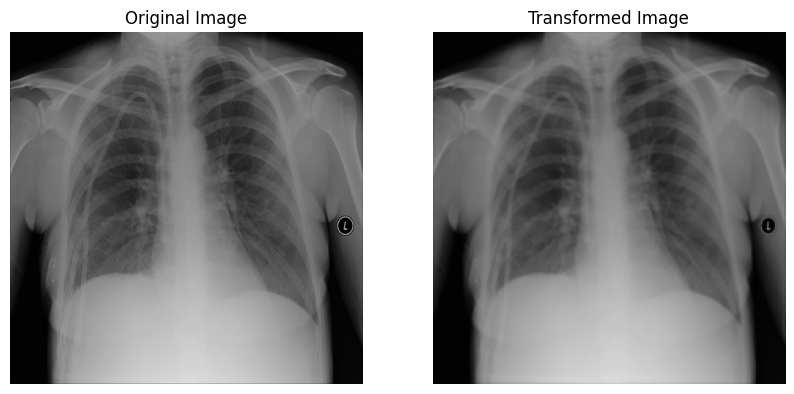

In [54]:
# Plot the original and transformed images
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image (PIL image)
axs[0].imshow(img)
axs[0].set_title('Original Image')
axs[0].axis('off')

# Display the transformed image (Tensor image)
axs[1].imshow(imshow_tensor(transformed_img))
axs[1].set_title('Transformed Image')
axs[1].axis('off')

plt.show()

In [55]:
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

In [56]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [57]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.batch_norm4 = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.batch_norm5 = nn.BatchNorm2d(256)
        self.relu5 = nn.ReLU()
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(256 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 2)
    def forward(self, x):
        x = self.maxpool1(self.relu1(self.batch_norm1(self.conv1(x))))
        x = self.maxpool2(self.relu2(self.batch_norm2(self.conv2(x))))
        x = self.maxpool3(self.relu3(self.batch_norm3(self.conv3(x))))
        x = self.maxpool4(self.relu4(self.batch_norm4(self.conv4(x))))
        x = self.maxpool5(self.relu5(self.batch_norm5(self.conv5(x))))
        x = self.dropout1(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


anantaJalil = CustomCNN().to(device)

print(anantaJalil)

CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=Tru

In [58]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(anantaJalil.parameters(), lr=0.001)

In [59]:
best_val_loss = float('inf')
patience = 3  # Number of epochs to wait for improvement
counter = 0  # Counter for how many epochs the validation loss hasn't improved

In [60]:
train_losses = []  # To store training losses during each epoch
val_losses = []    # To store validation losses during each epoch
train_accuracies = []  # To store training accuracies during each epoch
val_accuracies = []    # To store validation accuracies during each epoch
train_true_labels = []  # To store true labels during training
train_predicted_labels = []  # To store predicted labels during training
val_true_labels = []  # To store true labels during validation
val_predicted_labels = []  # To store predicted labels during validation
test_true_labels = []  # To store true labels during testing
test_predicted_labels = []  # To store predicted labels during testing

best_val_loss = float('inf')
patience = 3  # Number of epochs to wait for improvement
counter = 0  # Counter for how many epochs the validation loss hasn't improved

num_epochs = 20
for epoch in range(num_epochs):
    anantaJalil.train()
    train_true_labels_epoch = []
    train_predicted_labels_epoch = []

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = anantaJalil(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        train_true_labels_epoch.extend(labels.cpu().numpy())
        train_predicted_labels_epoch.extend(predicted.cpu().numpy())

    # Aggregate true and predicted labels for the entire training set
    train_true_labels.extend(train_true_labels_epoch)
    train_predicted_labels.extend(train_predicted_labels_epoch)

    # Calculate training accuracy and loss
    train_accuracy = accuracy_score(train_true_labels, train_predicted_labels)
    train_loss = criterion(outputs, labels)

    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss.item())

    # Validation loop
    anantaJalil.eval()
    val_true_labels_epoch = []
    val_predicted_labels_epoch = []

    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        val_loss = 0.0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = anantaJalil(inputs)
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item()

            val_true_labels_epoch.extend(labels.cpu().numpy())
            val_predicted_labels_epoch.extend(predicted.cpu().numpy())

        # Aggregate true and predicted labels for the entire validation set
        val_true_labels.extend(val_true_labels_epoch)
        val_predicted_labels.extend(val_predicted_labels_epoch)

        accuracy = total_correct / total_samples
        avg_val_loss = val_loss / len(val_loader)

        val_accuracies.append(accuracy)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}, Validation Accuracy: {accuracy:.4f}, Validation Loss: {avg_val_loss:.4f}")

        # Check for improvement in validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
        else:
            counter += 1

        # Check if early stopping criteria are met
        if counter >= patience:
            print(f"Early stopping at epoch {epoch + 1} due to no improvement in validation loss.")
            break

# Calculate confusion matrix, precision, recall, and F1 score for training and validation
train_cm = confusion_matrix(train_true_labels, train_predicted_labels)
val_cm = confusion_matrix(val_true_labels, val_predicted_labels)

train_precision, train_recall, train_f1_score, _ = precision_recall_fscore_support(train_true_labels, train_predicted_labels, average='binary')
val_precision, val_recall, val_f1_score, _ = precision_recall_fscore_support(val_true_labels, val_predicted_labels, average='binary')

print(f"Training Confusion Matrix:\n{train_cm}")
print(f"Training Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1-Score: {train_f1_score:.4f}")
print(f"Validation Confusion Matrix:\n{val_cm}")
print(f"Validation Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1-Score: {val_f1_score:.4f}")

Epoch 1/20: 100%|██████████| 92/92 [05:26<00:00,  3.55s/it]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1/20, Validation Accuracy: 0.9762, Validation Loss: 0.1352


Epoch 2/20: 100%|██████████| 92/92 [04:54<00:00,  3.20s/it]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 2/20, Validation Accuracy: 0.9857, Validation Loss: 0.0515


Epoch 3/20: 100%|██████████| 92/92 [05:14<00:00,  3.42s/it]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 3/20, Validation Accuracy: 0.9873, Validation Loss: 0.0623


Epoch 4/20: 100%|██████████| 92/92 [05:06<00:00,  3.33s/it]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 4/20, Validation Accuracy: 0.9873, Validation Loss: 0.0352


Epoch 5/20: 100%|██████████| 92/92 [05:17<00:00,  3.45s/it]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 5/20, Validation Accuracy: 0.9921, Validation Loss: 0.0293


Epoch 6/20: 100%|██████████| 92/92 [05:06<00:00,  3.34s/it]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 6/20, Validation Accuracy: 0.9921, Validation Loss: 0.0401


Epoch 7/20: 100%|██████████| 92/92 [05:08<00:00,  3.35s/it]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 7/20, Validation Accuracy: 0.9889, Validation Loss: 0.0575


Epoch 8/20: 100%|██████████| 92/92 [05:04<00:00,  3.31s/it]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 8/20, Validation Accuracy: 0.9937, Validation Loss: 0.0207


Epoch 9/20: 100%|██████████| 92/92 [04:59<00:00,  3.26s/it]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 9/20, Validation Accuracy: 0.9571, Validation Loss: 0.1316


Epoch 10/20: 100%|██████████| 92/92 [04:59<00:00,  3.25s/it]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 10/20, Validation Accuracy: 0.9857, Validation Loss: 0.0626


Epoch 11/20: 100%|██████████| 92/92 [05:00<00:00,  3.27s/it]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 11/20, Validation Accuracy: 0.9952, Validation Loss: 0.0070


Epoch 12/20: 100%|██████████| 92/92 [05:04<00:00,  3.31s/it]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 12/20, Validation Accuracy: 0.9984, Validation Loss: 0.0132


Epoch 13/20: 100%|██████████| 92/92 [04:57<00:00,  3.24s/it]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 13/20, Validation Accuracy: 0.9905, Validation Loss: 0.0223


Epoch 14/20: 100%|██████████| 92/92 [04:54<00:00,  3.20s/it]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 14/20, Validation Accuracy: 0.9810, Validation Loss: 0.0892
Early stopping at epoch 14 due to no improvement in validation loss.
Training Confusion Matrix:
[[34060   338]
 [  401  6361]]
Training Precision: 0.9495, Recall: 0.9407, F1-Score: 0.9451
Validation Confusion Matrix:
[[7163   61]
 [  58 1538]]
Validation Precision: 0.9619, Recall: 0.9637, F1-Score: 0.9628


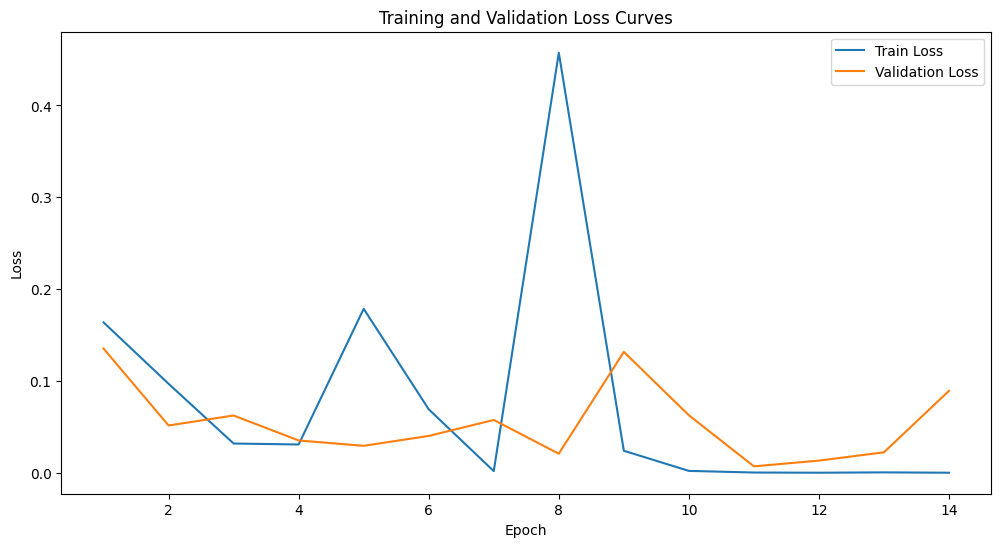

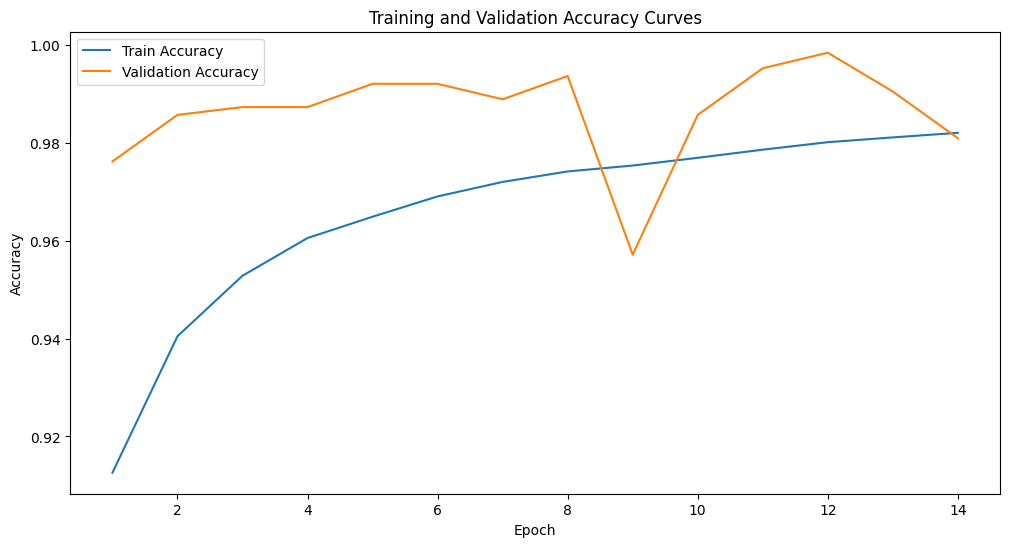

In [63]:
# Training and Validation Loss Curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Training and Validation Accuracy Curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


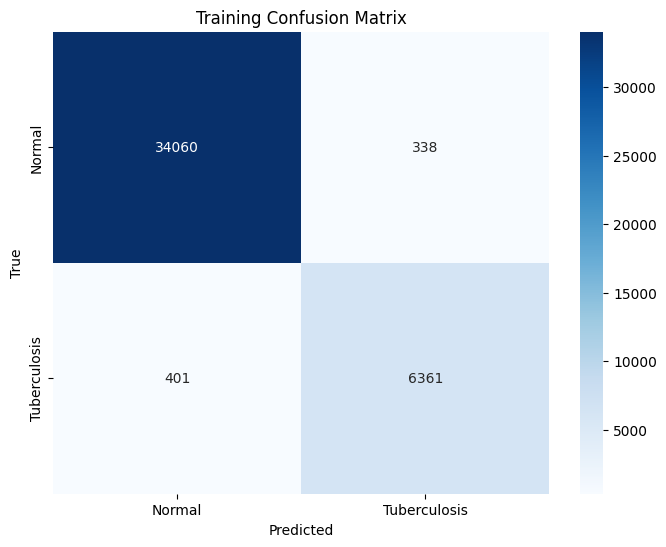

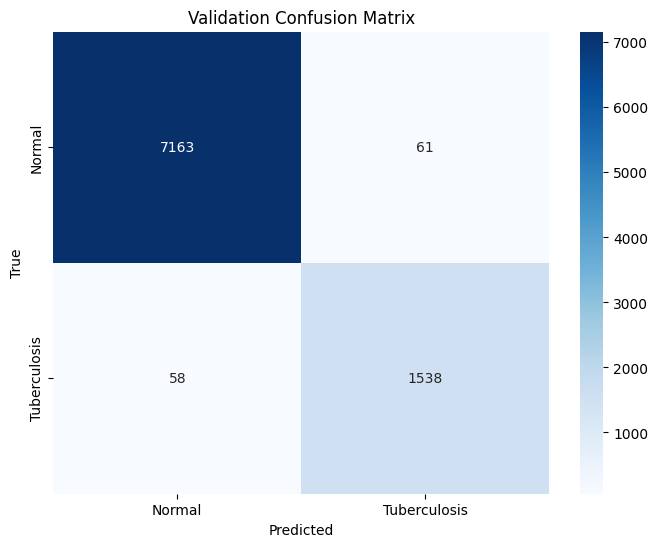

In [64]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Assuming you have the following lists populated:
# train_true_labels, train_predicted_labels, val_true_labels, val_predicted_labels

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot confusion matrices for training and validation
plot_confusion_matrix(train_true_labels, train_predicted_labels, labels=['Normal', 'Tuberculosis'], title='Training Confusion Matrix')
plot_confusion_matrix(val_true_labels, val_predicted_labels, labels=['Normal', 'Tuberculosis'], title='Validation Confusion Matrix')

In [65]:
test_true_labels = []  # To store true labels during testing
test_predicted_labels = []  # To store predicted labels during testing

anantaJalil.eval()
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = anantaJalil(inputs)
        _, predicted = torch.max(outputs, 1)
        test_true_labels.extend(labels.cpu().numpy())
        test_predicted_labels.extend(predicted.cpu().numpy())

# Calculate confusion matrix, precision, recall, and F1 score for testing
test_cm = confusion_matrix(test_true_labels, test_predicted_labels)
test_precision, test_recall, test_f1_score, _ = precision_recall_fscore_support(test_true_labels, test_predicted_labels, average='binary')

# Print and visualize the results
print(f"Test Confusion Matrix:\n{test_cm}")
print(f"Test Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-Score: {test_f1_score:.4f}")

Testing:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Testing: 100%|██████████| 20/20 [00:38<00:00,  1.94s/it]

Test Confusion Matrix:
[[527   0]
 [ 10  93]]
Test Precision: 1.0000, Recall: 0.9029, F1-Score: 0.9490


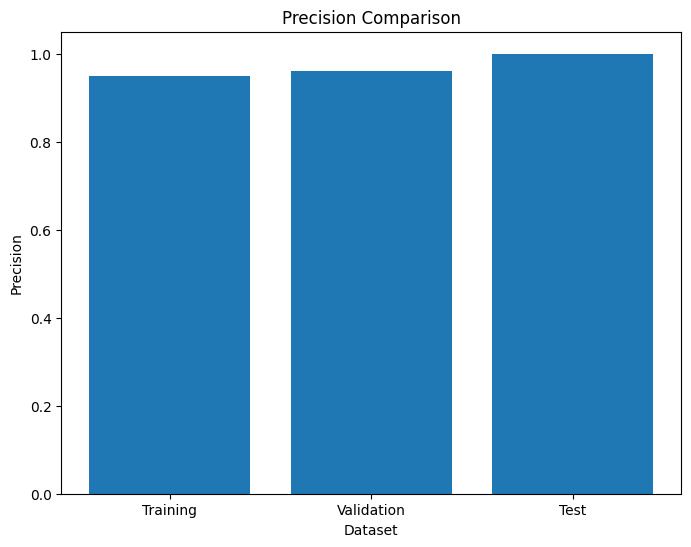

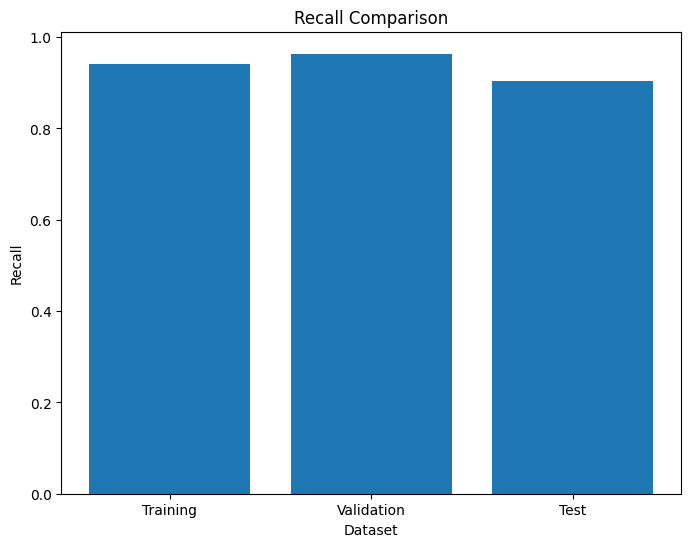

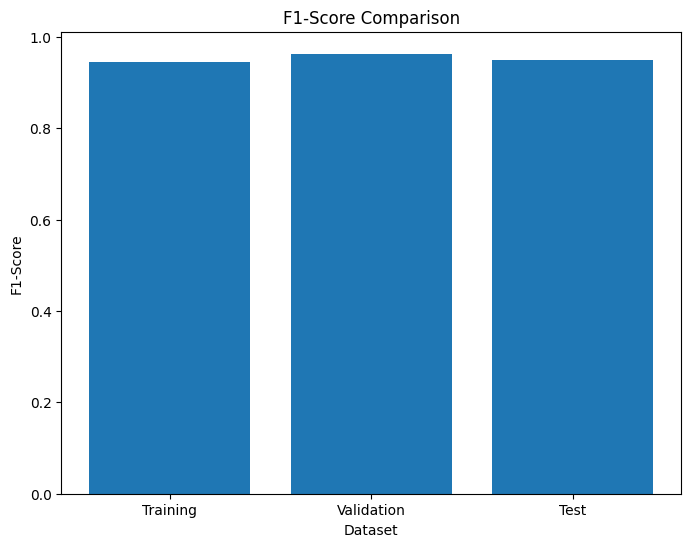

In [66]:
def plot_metrics_comparison(train_metric, val_metric, test_metric, metric_name, title):
    plt.figure(figsize=(8, 6))
    labels = ['Training', 'Validation', 'Test']
    values = [train_metric, val_metric, test_metric]
    plt.bar(labels, values)
    plt.title(title)
    plt.xlabel('Dataset')
    plt.ylabel(metric_name)
    plt.show()

# Plot precision comparison
plot_metrics_comparison(train_precision, val_precision, test_precision, 'Precision', 'Precision Comparison')

# Plot recall comparison
plot_metrics_comparison(train_recall, val_recall, test_recall, 'Recall', 'Recall Comparison')

# Plot F1 score comparison
plot_metrics_comparison(train_f1_score, val_f1_score, test_f1_score, 'F1-Score', 'F1-Score Comparison')